# Language model for email spam detection

## Introduction

In this research, I aim to determine which architecture is most effective for email spam detection and than the best model will be integrated in my application. Specifically, I will explore whether using complex blocks, such as LSTM, is justified for tasks of this nature. The primary models evaluated in this notebook include those with LSTM, GRU and bidirectional RNN blocks

## Data preprocessing and necessary libraries importing 

In [9]:
import pandas as pd
import numpy as np

import nltk 
from nltk.tokenize import word_tokenize 

from collections import Counter
from tqdm.auto import tqdm
import string
from typing import List

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import json

Data for my training, i took from  https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset

In [10]:
df = pd.read_csv("combined_data.csv")

In [41]:
df[df['label'] == 0]

,label,text
2,0,computer connection from cnn com wednesday es...
4,0,thanks for all your answers guys i know i shou...
5,0,larry king live at escapenumber escapenumber p...
6,0,michael pobega wrote i'm not sure if it's the ...
7,0,hi i have this error tr sample escapenumber es...
...,...,...
83436,0,hi list please see the following simple exampl...
83440,0,howstuffworks r lifestyle april escapenumber e...
83442,0,tewk wrote patch was to large to attach so htt...
83443,0,hi given a date how do i get the last date of ...


Example of the non-spam email

In [42]:
df.loc[2].text

" computer connection from cnn com wednesday escapenumber may escapenumber escapenumber escapenumber escapenumber pm edt in this report next generation toys read brain waves google expands personalization youtube wins webby old fashioned rabbit ears laptop review next generation toys read brain waves a startup company aims to add more realistic elements to video games by using brain wave reading technology to help game developers make gaming more realistic http www cnn com escapenumber tech fun games escapenumber escapenumber mind reading toys ap index html google expands personalization google is stepping up efforts to allow its users to personalize how they search the web http www cnn com escapenumber tech internet escapenumber escapenumber google personalization reut index html youtube wins webby the co founders youtube are among the winners of the annual webby online achievement awards http www cnn com escapenumber tech internet escapenumber escapenumber webby awards ap index html 

Example of the spam email

In [51]:
df.loc[3].text

'university degree obtain a prosperous future money earning power and the prestige that comes with having the career position you\x92ve always dreamed of diploma from prestigious non accredited unversities based on your present knowledge and professional experience if you qualify no required tests classes books or examinations confidentiality assured escapenumber escapenumber escapenumber escapenumber escapenumber hours a day escapenumber days a week including sundays and holidays sun escapenumber jun escapenumber escapenumber escapenumber escapenumber escapenumbershall borrowfor you have '

## Datasets preporation

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Vocabulary creation is done using words that appear more than **threshold = 25** times. In the vocabulary, we also include:  
**\<unk>** - for an unknown word  
**\<bos>** - for the beginning of a sentence  
**\<eos>** - for the end of a sentence  
**\<pad>** - padding token used to make all sentences in a batch the same length

In [13]:
words = Counter()

for text in tqdm(df.text.array):
    processed_text = text.lower().translate(
    str.maketrans("", "", string.punctuation))
    
    for token in word_tokenize(processed_text):
        words[token] += 1 
        
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])

count_treshold = 25

for token, cnt in words.items():
    if cnt >= count_treshold:
        vocab.add(token)
        
print(f"Length of the vocabular is {len(vocab)}")

  0%|          | 0/83448 [00:00<?, ?it/s]

Length of the vocabular is 28872


Creation of word dictionaries and their corresponding indexes, along with saving them for the application to function properly.

In [14]:
word2ind = {word : index for index, word in enumerate(vocab)}
ind2word = {index: word for index, word in enumerate(vocab)}

In [15]:
with open('word2ind.json', 'w') as f:
    json.dump(word2ind, f)

with open('ind2word.json', 'w') as f:
    json.dump(ind2word, f)

Creation of a dataset class that converts each word to its corresponding index and creates batches for training with texts and labels

In [16]:
class WordDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels
        assert len(sentences) == len(labels)
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
        
    def __getitem__(self, idx: int):
        processed_text = self.sentences[idx].lower().translate(
            str.maketrans("", "", string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id)
                               for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]
        
        return {
            'text': tokenized_sentence,
            'label': self.labels[idx] 
        }
    
    
    def __len__(self):
        return len(self.labels)
    
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256):
    lens = [len(sentence['text']) for sentence in input_batch]
    max_len = min(max(lens), max_len)
    
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_len]
        for i in range(max_len - len(sequence['text'])):
            sequence['text'].append(pad_id)
            
        new_batch.append(sequence['text'])
        
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([batch['label'] for batch in input_batch]).to(device)
    
    return {
        'text' : sequences,
        'label' : labels
    }

Splitting the data into training and validation sets and creating data loaders.

In [17]:
batch_size = 32
idx = np.random.choice(len(df.text.array), 10000)
train_data = df[~df.index.isin(idx)]
val_data = df.loc[idx]

In [18]:
train_dataset = WordDataset(train_data.text.array, train_data.label.array)
val_dataset = WordDataset(val_data.text.array, val_data.label.array)

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    val_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Train and evaluate functions

In [94]:
def train(model, criterion, optimizer, train_loader, eval_loader, num_epoch):
    losses_train = []
    losses_eval = []
    accuracy = []
    
    for epoch in range(num_epoch):
        epoch_losses_train = []
        epoch_losses_val = []
        
        # Training Phase
        model.train()
        for i, batch in enumerate(tqdm(train_loader, desc=f'Train epoch {epoch + 1}')):
            optimizer.zero_grad()
            logits = model(batch['text'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses_train.append(loss.item())
        
        # Evaluation Phase
        model.eval()
        with torch.no_grad():
            for batch in eval_loader:
                logits = model(batch['text'])
                loss = criterion(logits, batch['label'])
                epoch_losses_val.append(loss.item())
        
        avg_loss_train = sum(epoch_losses_train) / len(epoch_losses_train)
        avg_loss_eval = sum(epoch_losses_val) / len(epoch_losses_val)
        acc_eval = evalute(model, eval_loader)
        
        losses_train.append(avg_loss_train)
        losses_eval.append(avg_loss_eval)
        accuracy.append(acc_eval)
        
        print(f'Epoch {epoch + 1}/{num_epoch} - '
              f'Train Loss: {avg_loss_train:.4f}, '
              f'Eval Loss: {avg_loss_eval:.4f}, '
              f'Accuracy: {acc_eval:.4f}')
    
    return losses_train, losses_eval, accuracy


In [45]:
def evalute(model, eval_loader):
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_loader:
            logits = model(batch['text'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
   
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    
    return (predictions == target).float().mean().item()     

In [48]:
def show_loss_and_accuracy_history(losses_train, losses_eval, accuracy):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 

    # Plot losses
    ax1.plot(losses_train, label='Train', color='red')
    ax1.plot(losses_eval, label='Eval', color='blue')
    ax1.set_title('Loss History')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax1.grid(True)
    ax1.legend()

    
    ax2.plot(accuracy, label='Accuracy', color='green')
    ax2.set_title('Accuracy History')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.grid(True)
    ax2.legend() 
    
    plt.tight_layout() 
    plt.show()

## Language model with LSTM block

In [43]:
class LM(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind['<pad>'])
        self.LSTM = nn.LSTM(hidden_dim, int(hidden_dim / 2), num_layers = 3, batch_first = True, dropout = 0.1)
          
        self.linear = nn.Sequential(
            nn.Linear(int(hidden_dim / 2), hidden_dim),
            nn.Tanh(),
            nn.Dropout(p=0.3)
        )
        self.prediction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        
        output, (hidden, cell) = self.LSTM(embeddings)
        output = output.mean(dim = 1)
        
        return self.prediction(self.linear(output))

Variables for the training declaration

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [47]:
losses_train, losses_eval, accuracy = train(model, criterion, optimizer, train_dataloader, eval_dataloader, 10)

Train epoch 1:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.0905, Eval Loss: 0.0977, Accuracy: 0.9737


Train epoch 2:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.0344, Eval Loss: 0.0391, Accuracy: 0.9893


Train epoch 3:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.0194, Eval Loss: 0.0456, Accuracy: 0.9889


Train epoch 4:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.0127, Eval Loss: 0.0492, Accuracy: 0.9846


Train epoch 5:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.0090, Eval Loss: 0.0462, Accuracy: 0.9873


Train epoch 6:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.0063, Eval Loss: 0.0471, Accuracy: 0.9886


Train epoch 7:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.0052, Eval Loss: 0.0637, Accuracy: 0.9869


Train epoch 8:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.0042, Eval Loss: 0.0634, Accuracy: 0.9892


Train epoch 9:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.0032, Eval Loss: 0.0624, Accuracy: 0.9888


Train epoch 10:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.0028, Eval Loss: 0.0668, Accuracy: 0.9883


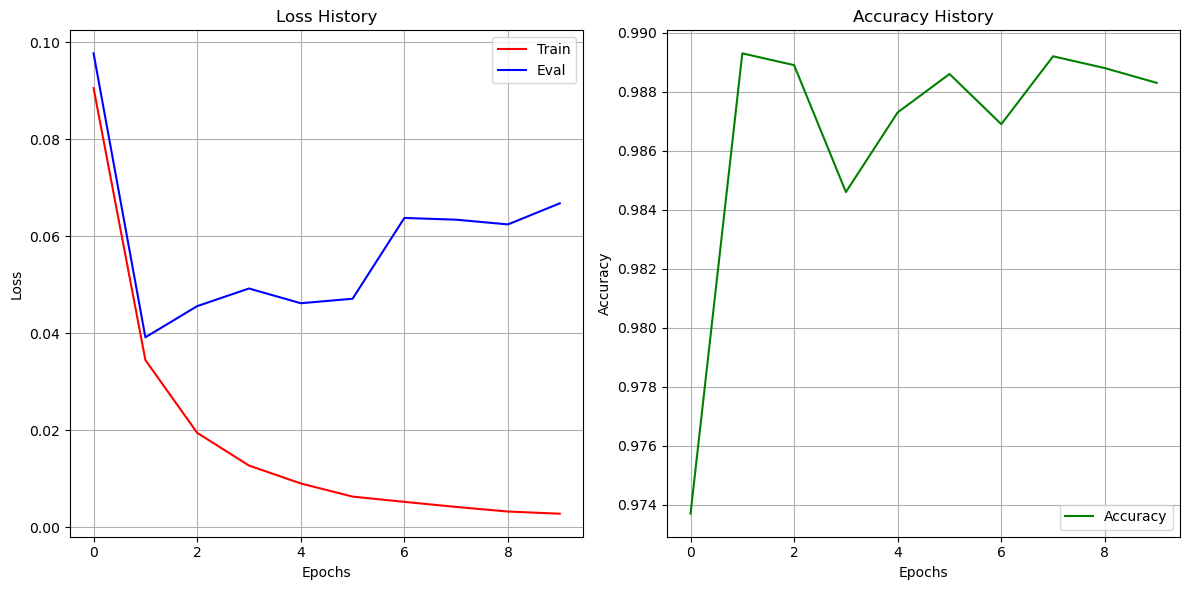

In [49]:
show_loss_and_accuracy_history(losses_train, losses_eval, accuracy)

In [50]:
torch.save(model, 'full_model.pth')

As we can see, the evaluation loss increases while accuracy also improves. We could add a few more epochs for training, but this may lead to overfitting of the model.

## Language model with GRU block

In [62]:
class LM(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind['<pad>'])
        self.GRU = nn.GRU(hidden_dim, int(hidden_dim / 2), num_layers = 3, batch_first = True, dropout = 0.1)
          
        self.linear = nn.Sequential(
            nn.Linear(int(hidden_dim / 2), hidden_dim),
            nn.Tanh(),
            nn.Dropout(p=0.3)
        )
        self.prediction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        
        output, hidden = self.GRU(embeddings)
        output = output.mean(dim = 1)
        
        return self.prediction(self.linear(output))

In [66]:
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [67]:
losses_train, losses_eval, accuracy = train(model, criterion, optimizer, train_dataloader, eval_dataloader, 10)

Train epoch 1:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.0895, Eval Loss: 0.0441, Accuracy: 0.9857


Train epoch 2:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.0316, Eval Loss: 0.0613, Accuracy: 0.9842


Train epoch 3:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.0190, Eval Loss: 0.0363, Accuracy: 0.9899


Train epoch 4:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.0128, Eval Loss: 0.0404, Accuracy: 0.9905


Train epoch 5:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.0097, Eval Loss: 0.0419, Accuracy: 0.9909


Train epoch 6:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.0082, Eval Loss: 0.0347, Accuracy: 0.9917


Train epoch 7:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.0055, Eval Loss: 0.0521, Accuracy: 0.9903


Train epoch 8:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.0048, Eval Loss: 0.0587, Accuracy: 0.9893


Train epoch 9:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.0050, Eval Loss: 0.0583, Accuracy: 0.9848


Train epoch 10:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.0044, Eval Loss: 0.0583, Accuracy: 0.9903


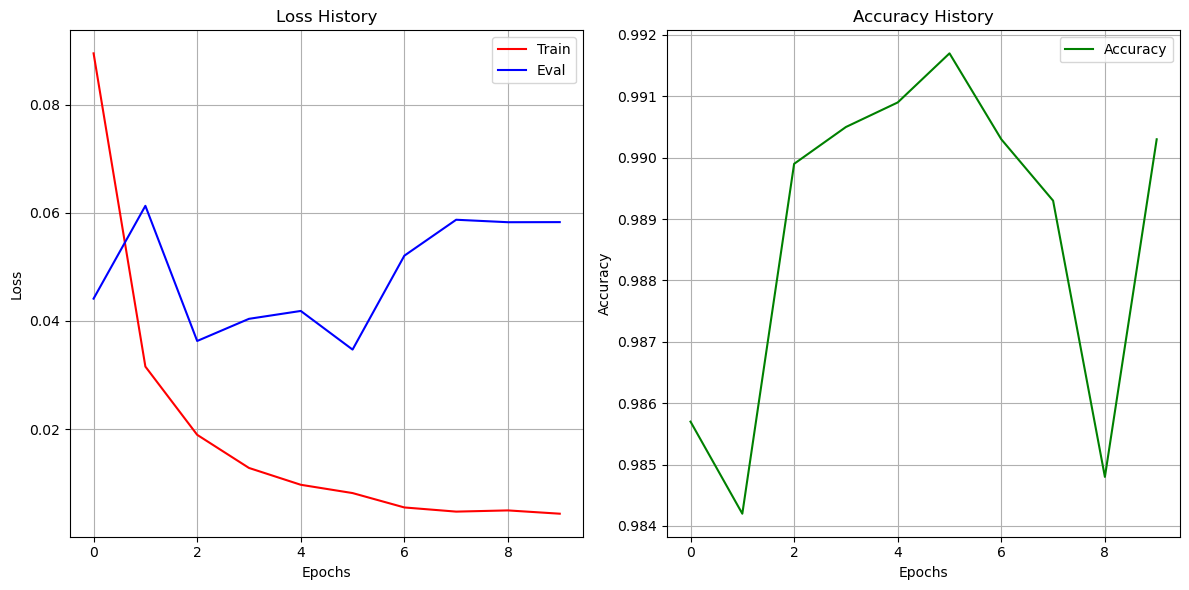

In [68]:
show_loss_and_accuracy_history(losses_train, losses_eval, accuracy)

In [70]:
torch.save(model, 'full_model.pth')

Here we can notice that for 6 epochs, our accuracy increased, but after that, it started to decrease, indicating that the model was overfitting. That's why I decided to train the model for only 6 epochs, but random initialization did not give me the same result.

In [71]:
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [72]:
losses_train, losses_eval, accuracy = train(model, criterion, optimizer, train_dataloader, eval_dataloader, 6)

Train epoch 1:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 1/6 - Train Loss: 0.0919, Eval Loss: 0.0484, Accuracy: 0.9864


Train epoch 2:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 2/6 - Train Loss: 0.0322, Eval Loss: 0.0507, Accuracy: 0.9862


Train epoch 3:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 3/6 - Train Loss: 0.0192, Eval Loss: 0.0394, Accuracy: 0.9892


Train epoch 4:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 4/6 - Train Loss: 0.0124, Eval Loss: 0.0457, Accuracy: 0.9892


Train epoch 5:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 5/6 - Train Loss: 0.0094, Eval Loss: 0.0504, Accuracy: 0.9880


Train epoch 6:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 6/6 - Train Loss: 0.0079, Eval Loss: 0.0504, Accuracy: 0.9896


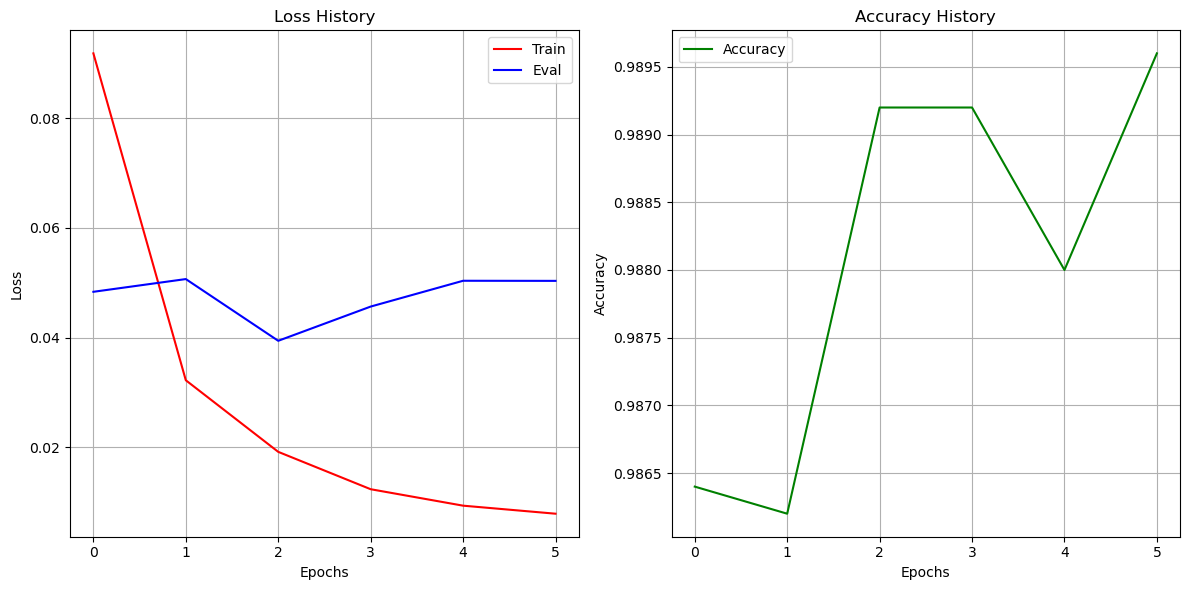

In [73]:
show_loss_and_accuracy_history(losses_train, losses_eval, accuracy)

## Language model with vanilla rnn block

In [95]:
class LM(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind['<pad>'])
        self.RNN = nn.RNN(hidden_dim, int(hidden_dim / 2), num_layers = 3, batch_first = True, dropout = 0.1, bidirectional = True)
          
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.Tanh(),
            nn.Dropout(p=0.3)
        )
        self.prediction = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        
        output, hidden = self.RNN(embeddings)
        output = output.mean(dim = 1)
        
        return self.prediction(self.linear(output))

In [96]:
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [97]:
losses_train, losses_eval, accuracy = train(model, criterion, optimizer, train_dataloader, eval_dataloader, 10)

Train epoch 1:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.1412, Eval Loss: 0.0715, Accuracy: 0.9787


Train epoch 2:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 2/10 - Train Loss: 0.0543, Eval Loss: 0.0604, Accuracy: 0.9806


Train epoch 3:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 3/10 - Train Loss: 0.0401, Eval Loss: 0.0459, Accuracy: 0.9860


Train epoch 4:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 4/10 - Train Loss: 0.0317, Eval Loss: 0.0468, Accuracy: 0.9868


Train epoch 5:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 5/10 - Train Loss: 0.0395, Eval Loss: 0.0529, Accuracy: 0.9855


Train epoch 6:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 6/10 - Train Loss: 0.0276, Eval Loss: 0.0494, Accuracy: 0.9865


Train epoch 7:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 7/10 - Train Loss: 0.0232, Eval Loss: 0.0568, Accuracy: 0.9863


Train epoch 8:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 8/10 - Train Loss: 0.0198, Eval Loss: 0.0623, Accuracy: 0.9876


Train epoch 9:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 9/10 - Train Loss: 0.0157, Eval Loss: 0.0493, Accuracy: 0.9854


Train epoch 10:   0%|          | 0/2315 [00:00<?, ?it/s]

Epoch 10/10 - Train Loss: 0.0108, Eval Loss: 0.0567, Accuracy: 0.9864


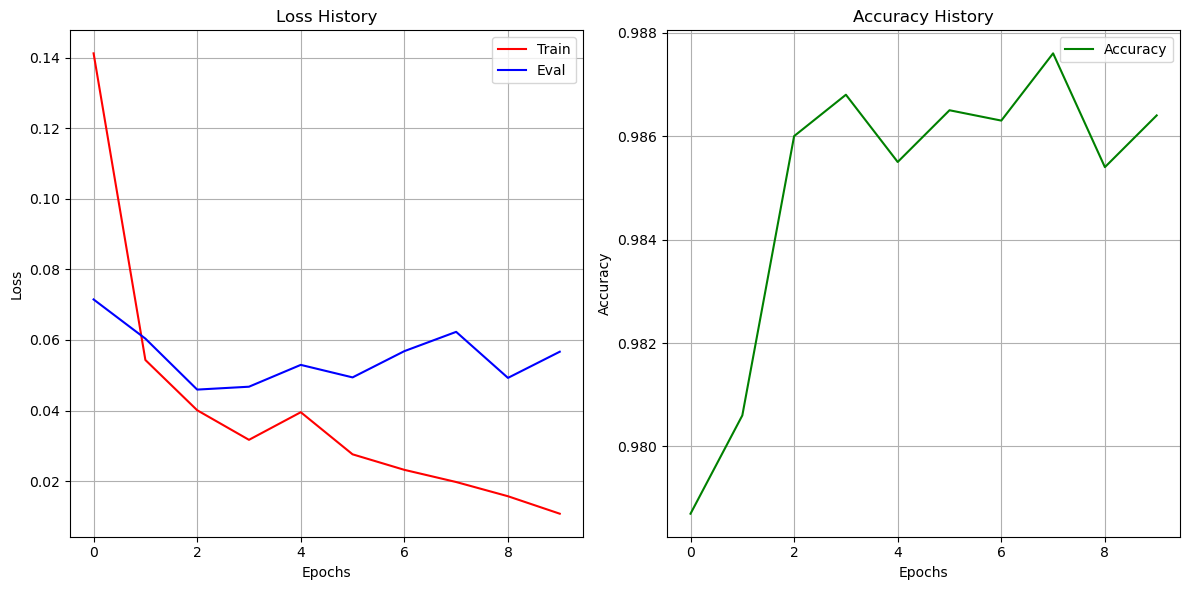

In [98]:
show_loss_and_accuracy_history(losses_train, losses_eval, accuracy)

Surprisingly, the vanilla RNN also performed very well, achieving 0.98 accuracy on my validation dataset. Even more, the model didn’t overfit as much as expected.

## Conclusion

After building and testing three models, I realized that the task of spam classification is relatively easy for neural networks. This task can also be easily implemented using standard programming methods. We simply need to identify certain keywords commonly found in spam emails and write a script that detects them. The more of these keywords a message contains, the higher the probability it’s spam. That’s why, after just one epoch of training, my models were able to achieve predictions with 98% accuracy. For my application, I chose the best model from all, which was the GRU